# Loan Approval Prediction - Random Forest Model

#### Business Case: To create a model that accurately predicts loan approval and automate the manual approval process. 

#### Goal: To accurately predict loan approvals without falsely approving too many loans that should be denied. 

#### Data Dictionary: 

![Data](LoanApprovalDataDictionary.png)

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
import pickle
from sklearn.tree import export_graphviz
#from dtreeviz.trees import dtreeviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import streamlit as st

### Import data, analyze descriptive statistics, drop NULLs

In [2]:
data = pd.read_csv('train.csv')

In [34]:
data.head()

array(['Rural', 'Urban', 'Semiurban'], dtype=object)

In [4]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
data.shape

(614, 13)

In [6]:
data['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [7]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [8]:
data = data.dropna()

In [9]:
data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Explore variable distributions and interactions

- Box plots, histograms, crosstabs

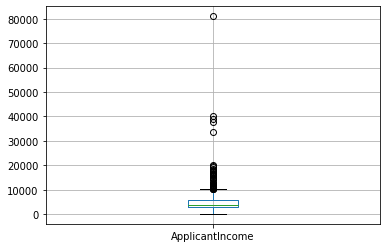

In [10]:
ApplicantIncome = data.boxplot(column = 'ApplicantIncome')
ApplicantIncome

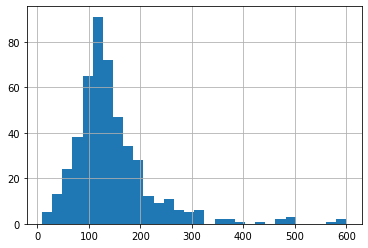

In [11]:
LoanAmount = data['LoanAmount'].hist(bins = 30)
LoanAmount

In [12]:
Property_Area = pd.crosstab(data['Property_Area'], data['Loan_Status'], margins = True)
Property_Area

Loan_Status,N,Y,All
Property_Area,,,
Rural,54,85,139
Semiurban,42,149,191
Urban,52,98,150
All,148,332,480


In [13]:
Married = pd.crosstab(data['Married'], data['Loan_Status'], margins = True)
Married

Loan_Status,N,Y,All
Married,,,
No,64,105,169
Yes,84,227,311
All,148,332,480


In [14]:
CreditHistory = pd.crosstab(data['Credit_History'], data['Loan_Status'], margins = True)
CreditHistory

Loan_Status,N,Y,All
Credit_History,,,
0.0,63,7,70
1.0,85,325,410
All,148,332,480


In [15]:
Gender = pd.crosstab(data['Gender'], data['Loan_Status'], margins = True)
Gender

Loan_Status,N,Y,All
Gender,,,
Female,32,54,86
Male,116,278,394
All,148,332,480


In [16]:
Self_employed = pd.crosstab(data['Self_Employed'], data['Loan_Status'], margins = True)
Self_employed

Loan_Status,N,Y,All
Self_Employed,,,
No,125,289,414
Yes,23,43,66
All,148,332,480


### Feature Engineering: Total Applicant Income 

To take into account both the borrower's and coborrower's (if applicable) income. 

In [17]:
data['TotalApplicantIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data

2022-09-04 17:55:04.787 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalApplicantIncome
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,2900.0
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,4106.0
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,8312.0
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,7583.0


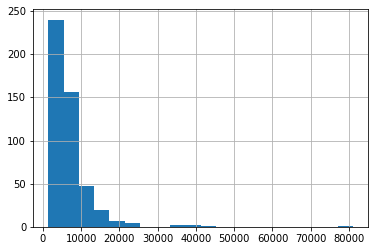

In [18]:
TotalAppInc_hist = data['TotalApplicantIncome'].hist(bins = 20)
TotalAppInc_hist

### Create dummy variables to prepare for Random Forest

In [19]:
gender_dummies = pd.get_dummies(data['Gender'])
data = pd.concat((data, gender_dummies), axis = 1)
data = data.drop(['Gender'], axis = 1)
data = data.drop(['Male'], axis = 1)
data = data.rename(columns = {'Female' : 'Gender'})
data

,Loan_ID,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalApplicantIncome,Gender
1,LP001003,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0
2,LP001005,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0
3,LP001006,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0
4,LP001008,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0
5,LP001011,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,2900.0,1
610,LP002979,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,4106.0,0
611,LP002983,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,8312.0,0
612,LP002984,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,7583.0,0


In [20]:
married_dummies = pd.get_dummies(data['Married'])
data = pd.concat((data, married_dummies), axis = 1)
data = data.drop(['Married'], axis = 1)
data = data.drop(['No'], axis = 1)
data = data.rename(columns = {'Yes' : 'Married'})
data

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalApplicantIncome,Gender,Married
1,LP001003,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0,1
2,LP001005,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0,1
3,LP001006,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0,1
4,LP001008,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0,0
5,LP001011,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y,2900.0,1,0
610,LP002979,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y,4106.0,0,1
611,LP002983,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y,8312.0,0,1
612,LP002984,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y,7583.0,0,1


In [21]:
LoanStatus_dummies = pd.get_dummies(data['Loan_Status'])
data = pd.concat((data, LoanStatus_dummies), axis = 1)
data = data.drop(['Loan_Status'], axis = 1)
data = data.drop(['N'], axis = 1)
data = data.rename(columns = {'Y' : 'Loan_Approved'})
data

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalApplicantIncome,Gender,Married,Loan_Approved
1,LP001003,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,6091.0,0,1,0
2,LP001005,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,3000.0,0,1,1
3,LP001006,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,4941.0,0,1,1
4,LP001008,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,6000.0,0,0,1
5,LP001011,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,9613.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,2900.0,1,0,1
610,LP002979,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,4106.0,0,1,1
611,LP002983,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,8312.0,0,1,1
612,LP002984,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,7583.0,0,1,1


In [22]:
data.astype({'Credit_History' : int})

,Loan_ID,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,TotalApplicantIncome,Gender,Married,Loan_Approved
1,LP001003,1,Graduate,No,4583,1508.0,128.0,360.0,1,Rural,6091.0,0,1,0
2,LP001005,0,Graduate,Yes,3000,0.0,66.0,360.0,1,Urban,3000.0,0,1,1
3,LP001006,0,Not Graduate,No,2583,2358.0,120.0,360.0,1,Urban,4941.0,0,1,1
4,LP001008,0,Graduate,No,6000,0.0,141.0,360.0,1,Urban,6000.0,0,0,1
5,LP001011,2,Graduate,Yes,5417,4196.0,267.0,360.0,1,Urban,9613.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0,Graduate,No,2900,0.0,71.0,360.0,1,Rural,2900.0,1,0,1
610,LP002979,3+,Graduate,No,4106,0.0,40.0,180.0,1,Rural,4106.0,0,1,1
611,LP002983,1,Graduate,No,8072,240.0,253.0,360.0,1,Urban,8312.0,0,1,1
612,LP002984,2,Graduate,No,7583,0.0,187.0,360.0,1,Urban,7583.0,0,1,1


In [23]:
data[data['Married'] == 1].shape[0] 

311

### Random Forest Model: 
-Split training and testing data (80% & 20%)

-Forest of 100 trees

-Min 5 samples in a leaf to avoid too many splits

-Max depth of 2: 
    - Max depth of >2 was not adding to the model and predictive power
    - Max depth of 2 avoids overfitting
    
#### Explanatory/Dependent Variable (Y): 
Loan_Approved
#### Independent Variables: 
Gender, Married, TotalApplicantIncome, LoanAmount, Credit_History

In [24]:
#independent variables
features = ['Gender', 'Married', 'TotalApplicantIncome', 'LoanAmount', 'Credit_History']
X = data[features]
#dependent variables
dependent = 'Loan_Approved'
y = data[dependent]
X.shape, y.shape

#split dataset into train (80%) and test (20%), shuffle observations
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10, shuffle = True)

#build random forest model, limit max depth to avoid overfitting
forest = RandomForestClassifier(max_depth=2, random_state = 10, n_estimators = 100, min_samples_leaf=5) 
model = forest.fit(x_train, y_train)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

### Feature Importance: 

Established Credit_History is the most important variable in predicting loan approval, followed by TotalApplicantIncome.

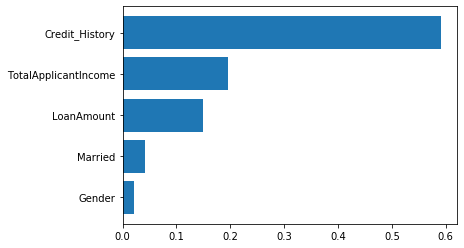

In [25]:
feature_importance = list(zip(features,forest.feature_importances_))
feature_importance.sort(key = lambda x : x[1])
plt.barh([x[0] for x in feature_importance],[x[1] for x in feature_importance])
plt.show()

## A Decision Tree from the Random Forest

- Gini Index: shows the explanatory power of a variable, is 0 when all samples are of the same class (best possible impurity and information gain)
- Class: shows the predicted class (0 = Not approved, 1 = Approved)

In [26]:
estimator = model.estimators_[50]
estimator
model.estimators_[50].tree_.max_depth

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (32,20), dpi=500)
sk.tree.plot_tree(estimator, filled=True, fontsize = 10, feature_names=features, class_names = True)
fig.savefig('tree.png')

## Accuracy, Precision, Recall, & F1 Score

#### Accuracy 

= (TP + TN) / (TP + TN + FP + FN) = TruePositives&Negatives / All 

What % of values were correctly predicted?


#### Precision 

= TP / (TP + FP) = TruePositive / PredictedPositives

What % of predicted positives are actually positive?


#### Recall 

= TP / (TP + FN) = TruePositive / ActualPositives

What % of actual positives are predicted positive?


#### F1 Score

= 2 * (Precision * Recall) / (Precision + Recall)

Balances Precision and Recall (weighted average), useful for datasets with class imbalance (observations have a large number of Actual Negatives), take false positives and negatives into account.

In [27]:
#Predicted Y (outcome) values for test and training observations
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

#Accuracy
accuracy_train = accuracy_score(y_train,pred_train)
accuracy_test = accuracy_score(y_test,pred_test)


#Precision
precision_train = sk.metrics.precision_score(y_train,pred_train)
precision_test = sk.metrics.precision_score(y_test,pred_test)

#Recall
recall_train = sk.metrics.recall_score(y_train,pred_train)
recall_test = sk.metrics.recall_score(y_test,pred_test)

#F1
f1_train = (2 * precision_train * recall_train) / (precision_train + recall_train)
f1_test = (2 * precision_test * recall_test) / (precision_test + recall_test)


print('Accuracy Train:',accuracy_train,'Accuracy Test:',accuracy_test)
print('Precision Train:',precision_train,'Precision Test:',precision_test)
print('Recall Train:',recall_train,'Recall Test:',recall_test)
print('F1 Train:',f1_train,'F1 Test:',f1_test)

Accuracy Train: 0.8098958333333334 Accuracy Test: 0.8020833333333334
Precision Train: 0.7962962962962963 Precision Test: 0.7790697674418605
Recall Train: 0.9735849056603774 Recall Test: 1.0
F1 Train: 0.8760611205432938 F1 Test: 0.8758169934640523


In [28]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.34      0.51        29
           1       0.78      1.00      0.88        67

    accuracy                           0.80        96
   macro avg       0.89      0.67      0.69        96
weighted avg       0.85      0.80      0.77        96



## Business Context and Model Evaluation

From a business perspective, we want to avoid predicting a positve loan approval when it was actually denied (False Positives), so ***Precision*** will be our best measures for the model. This will ensure that we are accurately predicting loan approvals and that predicted approvals are actual approvals (precision). 

Since this model produces very similar precision scores on both the training and testing data, this model appears to be the best fit to maximize predictive power on the training dataset without overfitting and sacrificing predictability on the testing data. 

## Symptoms of Overfitting and Underfitting: 

#### Overfitting: 
- Relies too much on the training data. Shows great performance on training data but a drop in performance on testing data.
- Need to reduce model complexity and remove layers & features from the model. 


#### Underfitting: 
- A failure ti learn relationships in training data, poor performance on training data.
- Need to increase model complexity and add layers & features to the model.

In [29]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.34      0.51        29
           1       0.78      1.00      0.88        67

    accuracy                           0.80        96
   macro avg       0.89      0.67      0.69        96
weighted avg       0.85      0.80      0.77        96



## Confusion Matrix

- Identifies True Positives, True Negatives, False Positives, False Negatives based on Predicted and Actual Values in the following format:

|         |Predicted Negative|Predicted Positive|
|----               |----    |----    |
|**Actual Negative**|**TN**  | FP     |
|**Actual Positive**| FN     |**TP**  |


                                        FP is Type I error, FN is Type II error

In [30]:
confusion_matrix = confusion_matrix(y_test, pred_test)
confusion_matrix

array([[10, 19],
       [ 0, 67]])

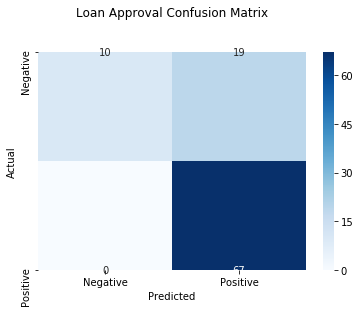

In [31]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt = '')

ax.set_title('Loan Approval Confusion Matrix\n\n');
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

 #### Testing model prediction with new inputs to prepare for web app:

In [32]:
inputs = [[1, 1, 0, 71, 0]]

pred_inputs = model.predict(inputs)
pred_inputs[0]

0

#### Next steps: Use pickle file to transfer model to web app python code

In [33]:
# pickle_out = open("Loan_Approval_Prediction.pkl", mode = "wb") 
# pickle.dump(model, pickle_out) 
# pickle_out.close()